# Machine Learning: Assignment #2

Bárbara Nóbrega Galiza – 202408654​

Cláudia Oliveira - 202005668​

Marta Campos - 202008344

In [738]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
from charlson import *

In [739]:
# Diagnoses
diag = pd.read_csv('tables/DIAGNOSES_ICD.csv')

# Diagnoses and their descriptions
desc = pd.read_csv('tables/D_ICD_DIAGNOSES.csv')

top_codes = diag['ICD9_CODE'].value_counts().head(15).reset_index()
top_codes.columns = ['ICD9_CODE', 'count']

top_diseases = top_codes.merge(desc[['ICD9_CODE', 'SHORT_TITLE']], on='ICD9_CODE', how='left')

print(top_diseases)

   ICD9_CODE  count               SHORT_TITLE
0       4019  20703          Hypertension NOS
1       4280  13111                   CHF NOS
2      42731  12891       Atrial fibrillation
3      41401  12429  Crnry athrscl natve vssl
4       5849   9119  Acute kidney failure NOS
5      25000   9058  DMII wo cmp nt st uncntr
6       2724   8690    Hyperlipidemia NEC/NOS
7      51881   7497  Acute respiratry failure
8       5990   6555  Urin tract infection NOS
9      53081   6326         Esophageal reflux
10      2720   5930   Pure hypercholesterolem
11      V053   5779  Need prphyl vc vrl hepat
12      V290   5519    NB obsrv suspct infect
13      2859   5406                Anemia NOS
14      2449   4917        Hypothyroidism NOS


Load chartevents filtering by admissions with the disease chosen

In [740]:
# Congestive heart failure
#d = diag[diag['ICD9_CODE'] == "4280"]
# All types of heart failure
diag['ICD9_CODE'] = diag['ICD9_CODE'].astype(str)
d = diag[diag['ICD9_CODE'].str.startswith('428')]

diagnoses_disease = d[d['SEQ_NUM'] == 1.0].copy()
hadm_ids = diagnoses_disease['HADM_ID'].unique()
patients_ids = diagnoses_disease['SUBJECT_ID'].unique()

In [741]:
chunksize = 100000 
filtered_chunks = []

for chunk in pd.read_csv('tables/CHARTEVENTS.csv', chunksize=chunksize, low_memory=False):
    chunk = chunk[chunk['HADM_ID'].isin(hadm_ids)]
    filtered_chunks.append(chunk)

chartevents_filtered = pd.concat(filtered_chunks)

In [742]:
print(len(diagnoses_disease))
len(chartevents_filtered)

1488


986502

### Data Preprocessing

Loading more datasets

In [743]:
# Patient demographic information
patients = pd.read_csv('tables/PATIENTS.csv')
patients = patients[patients['SUBJECT_ID'].isin(patients_ids)]

# Hospital admissions 
admissions = pd.read_csv('tables/ADMISSIONS.csv')
admissions = admissions[admissions['HADM_ID'].isin(hadm_ids)]

icustays = pd.read_csv('tables/ICUSTAYS.csv')
icustays = icustays[icustays['HADM_ID'].isin(hadm_ids)]

# Dictionary that maps ITEMIDs to their names/descriptions
items = pd.read_csv('tables/D_ITEMS.csv')

In [744]:
print(len(icustays))
print(len(admissions)) # one diagnose by admission
print(len(patients))

1623
1488
1268


Adding comordibities

In [745]:
diag_all = diag[diag['HADM_ID'].isin(hadm_ids) & (diag['SEQ_NUM'] > 1)]
grouped = diag_all.groupby('HADM_ID')['ICD9_CODE'].apply(list).reset_index()

grouped['charlson_cat'] = grouped['ICD9_CODE'].apply(mapear_charlson)
grouped['charlson_index'] = grouped['charlson_cat'].apply(calcular_cci)
grouped.head(5)

,HADM_ID,ICD9_CODE,charlson_cat,charlson_index
0,100050,"[99811, 5990, 4241, 41401, 2875, 99791, 42731,...",{},0
1,100061,"[5849, 4160, 4280, 496, 25060, 3572, 4439, V45...","{DiabComp, CHF, PVD}",4
2,100136,"[51882, 486, 42731, 4019, 2724, 45829, E9444, ...",{},0
3,100182,"[5849, 5854, 7455, 2761, 4139, 4280, 496, V667...","{Diabetes, Renal, PVD, CHF}",5
4,100199,"[51881, 2800, 5781, 42789, 5563, 7806, 25000, ...",{Diabetes},1


In [746]:
diag_seq2 = diag[diag['SEQ_NUM'] == 2.0][['HADM_ID', 'ICD9_CODE']].rename(columns={'ICD9_CODE': 'comorbidity1'})
diagnoses_disease = diagnoses_disease.merge(diag_seq2, on='HADM_ID', how='left')
diagnoses_disease['comorbidity1'] = diagnoses_disease['comorbidity1'].fillna(0)

diag_seq2 = diag[diag['SEQ_NUM'] == 3.0][['HADM_ID', 'ICD9_CODE']].rename(columns={'ICD9_CODE': 'comorbidity2'})
diagnoses_disease = diagnoses_disease.merge(diag_seq2, on='HADM_ID', how='left')
diagnoses_disease['comorbidity2'] = diagnoses_disease['comorbidity2'].fillna(0)

diagnoses_disease.head(15)

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,comorbidity1,comorbidity2
0,2154,175,176764,1.0,42831,51881,5070
1,2163,176,135828,1.0,4280,42731,4251
2,2172,177,143120,1.0,4280,51881,5119
3,2460,199,185360,1.0,4280,4254,4240
4,3596,305,122211,1.0,42820,99859,5070
5,2056,165,170252,1.0,42823,51881,49121
6,2516,205,135671,1.0,4280,4240,5990
7,4092,351,174800,1.0,4280,78057,6110
8,3775,323,106158,1.0,4280,99672,99762
9,3784,323,128132,1.0,4280,78551,51881


Percentage of the frequency explained by the top 5 comorbities: 44.01881720430107 %


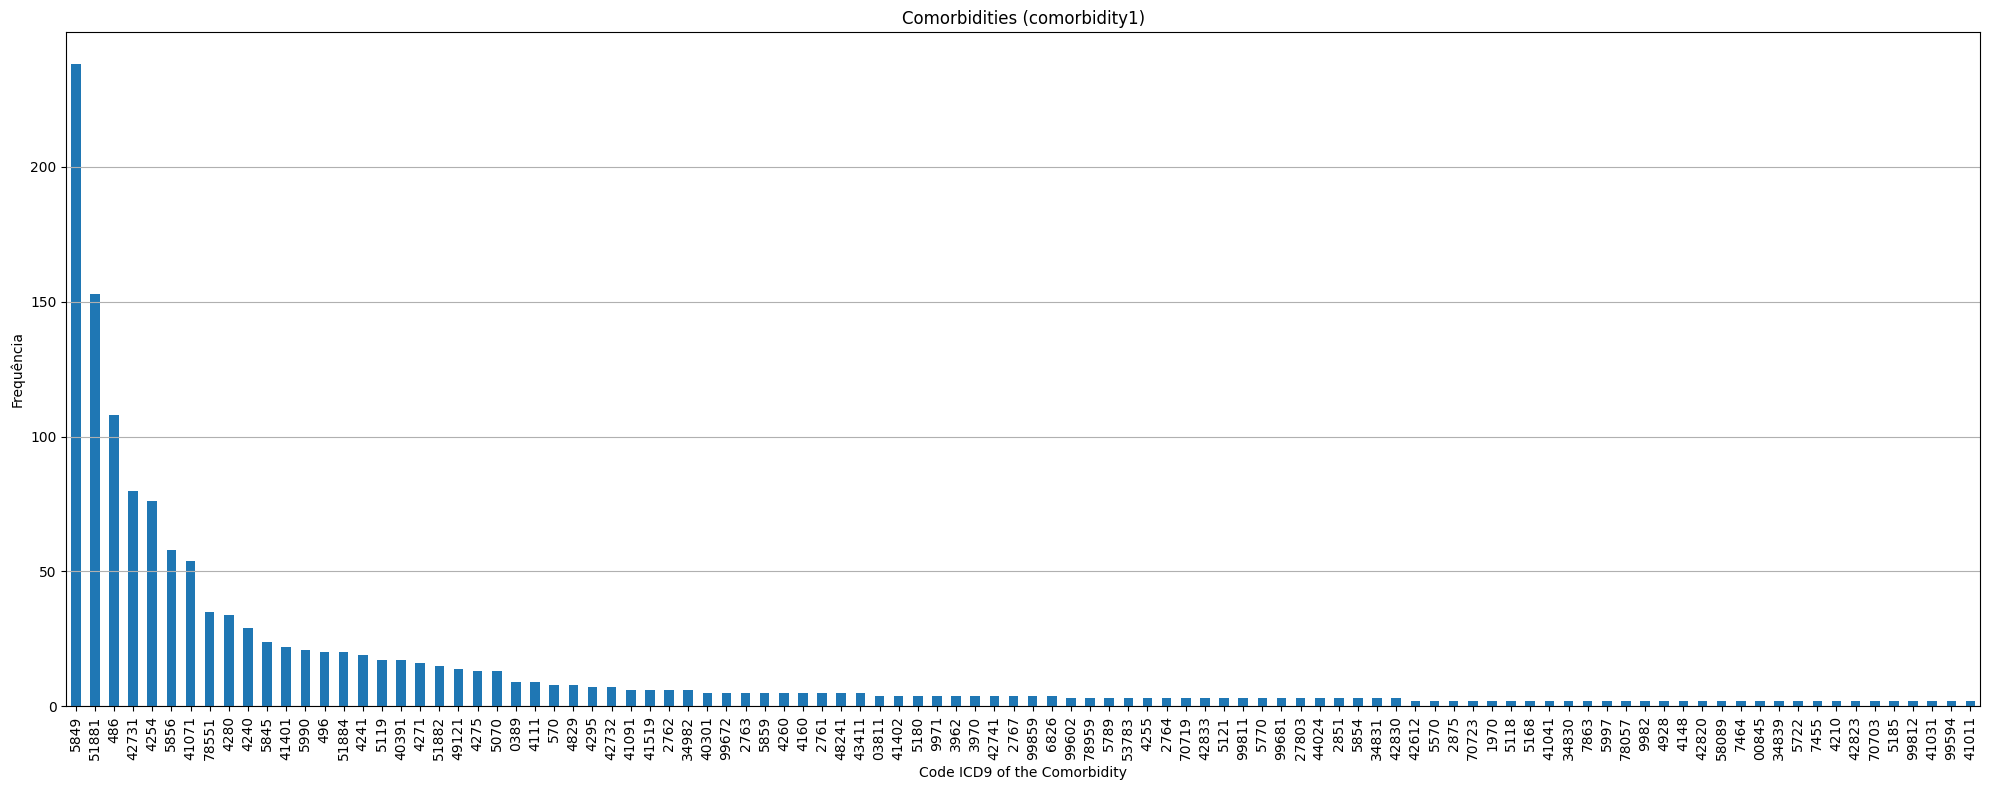

comorbidity1
5849     238
51881    153
486      108
42731     80
4254      76
Name: count, dtype: int64

In [747]:
counts1 = diagnoses_disease['comorbidity1'].value_counts()

c1 = sum(counts1[0:5])/sum(counts1[:]) 
print("Percentage of the frequency explained by the top 5 comorbities: " + str(c1*100) + " %")

plt.figure(figsize=(20,8))
counts_plot = counts1[0:100]
counts_plot.plot(kind='bar')
plt.title('Comorbidities (comorbidity1)')
plt.xlabel('Code ICD9 of the Comorbidity')
plt.ylabel('Frequência')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

counts1[0:5]

Percentage of the frequency explained by the top 5 comorbities2: 26.478494623655912 %


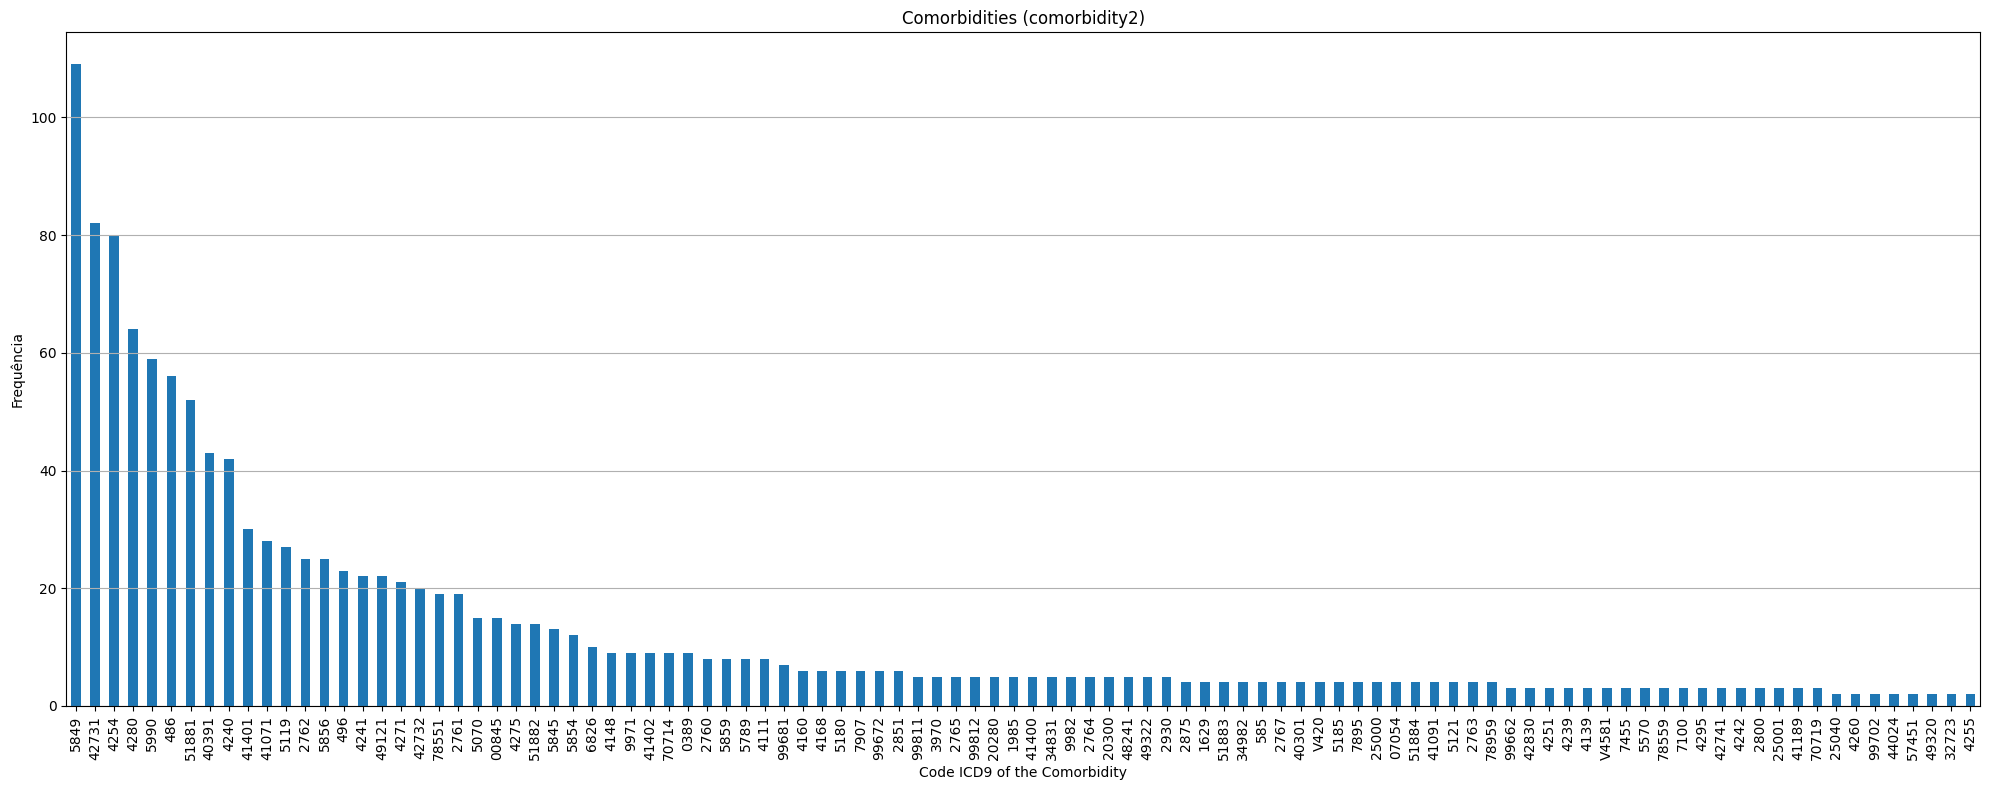

comorbidity2
5849     109
42731     82
4254      80
4280      64
5990      59
Name: count, dtype: int64

In [748]:
counts2 = diagnoses_disease['comorbidity2'].value_counts()

c2 = sum(counts2[0:5])/sum(counts2) 
print("Percentage of the frequency explained by the top 5 comorbities2: " + str(c2*100) + " %")

plt.figure(figsize=(20,8))
counts_plot = counts2[0:100]
counts_plot.plot(kind='bar')
plt.title('Comorbidities (comorbidity2)')
plt.xlabel('Code ICD9 of the Comorbidity')
plt.ylabel('Frequência')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

counts2[0:5]

In [749]:
print(f"Columns of Diagnosis: {diag.columns} \n")
print(f"Columns of Description of Diseases: {desc.columns} \n")
print(f"Columns of ICU Stays: {icustays.columns} \n")
print(f"Columns of Chart Events: {chartevents_filtered.columns} \n")
print(f"Columns of Patients: {patients.columns} \n")
print(f"Columns of Admissions: {admissions.columns} \n")

Columns of Diagnosis: Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'SEQ_NUM', 'ICD9_CODE'], dtype='object') 

Columns of Description of Diseases: Index(['ROW_ID', 'ICD9_CODE', 'SHORT_TITLE', 'LONG_TITLE'], dtype='object') 

Columns of ICU Stays: Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'DBSOURCE',
       'FIRST_CAREUNIT', 'LAST_CAREUNIT', 'FIRST_WARDID', 'LAST_WARDID',
       'INTIME', 'OUTTIME', 'LOS'],
      dtype='object') 

Columns of Chart Events: Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'ITEMID', 'CHARTTIME',
       'STORETIME', 'CGID', 'VALUE', 'VALUENUM', 'VALUEUOM', 'WARNING',
       'ERROR', 'RESULTSTATUS', 'STOPPED'],
      dtype='object') 

Columns of Patients: Index(['ROW_ID', 'SUBJECT_ID', 'GENDER', 'DOB', 'DOD', 'DOD_HOSP', 'DOD_SSN',
       'EXPIRE_FLAG'],
      dtype='object') 

Columns of Admissions: Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
       'DISCHAR

### Data Preparation

In [750]:
top5 = diagnoses_disease['comorbidity1'].value_counts().index[:5]

# Create a new column for dummies but only for those top 5
diagnoses_disease['comorbidity1_top5'] = diagnoses_disease['comorbidity1'].where(
    diagnoses_disease['comorbidity1'].isin(top5), other='Other'
)

# Create dummies (excluding 'Other' if you want to drop it)
dummies = pd.get_dummies(diagnoses_disease['comorbidity1_top5'], prefix='comorbidity1')

# Optionally drop the 'Other' column (you can skip this line if you want to keep it)
dummies = dummies.drop(columns=['comorbidity1_Other'], errors='ignore')

# Concatenate back to the dataframe
diagnoses_disease = pd.concat([diagnoses_disease, dummies], axis=1)

In [751]:
top5 = diagnoses_disease['comorbidity2'].value_counts().index[:5]

# Create a new column for dummies but only for those top 5
diagnoses_disease['comorbidity2_top5'] = diagnoses_disease['comorbidity2'].where(
    diagnoses_disease['comorbidity2'].isin(top5), other='Other'
)

# Create dummies (excluding 'Other' if you want to drop it)
dummies = pd.get_dummies(diagnoses_disease['comorbidity2_top5'], prefix='comorbidity2')

# Optionally drop the 'Other' column (you can skip this line if you want to keep it)
dummies = dummies.drop(columns=['comorbidity2_Other'], errors='ignore')

# Concatenate back to the dataframe
diagnoses_disease = pd.concat([diagnoses_disease, dummies], axis=1)

In [752]:
len(diagnoses_disease)
diagnoses_disease.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,comorbidity1,comorbidity2,comorbidity1_top5,comorbidity1_4254,comorbidity1_42731,comorbidity1_486,comorbidity1_51881,comorbidity1_5849,comorbidity2_top5,comorbidity2_4254,comorbidity2_42731,comorbidity2_4280,comorbidity2_5849,comorbidity2_5990
0,2154,175,176764,1.0,42831,51881,5070,51881,False,False,False,True,False,Other,False,False,False,False,False
1,2163,176,135828,1.0,4280,42731,4251,42731,False,True,False,False,False,Other,False,False,False,False,False
2,2172,177,143120,1.0,4280,51881,5119,51881,False,False,False,True,False,Other,False,False,False,False,False
3,2460,199,185360,1.0,4280,4254,4240,4254,True,False,False,False,False,Other,False,False,False,False,False
4,3596,305,122211,1.0,42820,99859,5070,Other,False,False,False,False,False,Other,False,False,False,False,False


In [753]:
icustays['INTIME'] = pd.to_datetime(icustays['INTIME'])
chartevents_filtered['CHARTTIME'] = pd.to_datetime(chartevents_filtered['CHARTTIME'])

# Merge on ICUSTAY_ID or HADM_ID depending on your data
merged = pd.merge(chartevents_filtered, icustays[['ICUSTAY_ID', 'INTIME']], on='ICUSTAY_ID', how='inner')

# Compute time difference
merged['DAYS_FROM_INTIME'] = (merged['CHARTTIME'] - merged['INTIME']).dt.total_seconds() / 86400

# Filter for events within the first 24 hours
chartevents_first_day = merged[merged['DAYS_FROM_INTIME'] < 1].copy()

In [754]:
print(len(chartevents_first_day))
chartevents_first_day.head()

274508


,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,STORETIME,CGID,VALUE,VALUENUM,VALUEUOM,WARNING,ERROR,RESULTSTATUS,STOPPED,INTIME,DAYS_FROM_INTIME
0,27124,165,170252,247247.0,223761,2170-10-03 18:00:00,2170-10-03 18:43:00,16187.0,97.3,97.3,?F,0.0,0.0,NaN,NaN,2170-10-03 17:17:53,0.029248
1,27125,165,170252,247247.0,225664,2170-10-03 18:00:00,2170-10-03 18:43:00,20277.0,174.0,174.0,NaN,0.0,0.0,NaN,NaN,2170-10-03 17:17:53,0.029248
2,27126,165,170252,247247.0,220277,2170-10-03 18:35:00,2170-10-03 18:43:00,16187.0,99.0,99.0,%,0.0,0.0,NaN,NaN,2170-10-03 17:17:53,0.053553
3,27127,165,170252,247247.0,220045,2170-10-03 18:36:00,2170-10-03 18:43:00,16187.0,73.0,73.0,bpm,0.0,0.0,NaN,NaN,2170-10-03 17:17:53,0.054248
4,27128,165,170252,247247.0,220210,2170-10-03 18:36:00,2170-10-03 18:43:00,16187.0,19.0,19.0,insp/min,0.0,0.0,NaN,NaN,2170-10-03 17:17:53,0.054248


In [755]:
dataset = icustays[['ICUSTAY_ID', 'SUBJECT_ID', 'HADM_ID', 'LOS']]

print(len(dataset))

dataset = dataset.merge(admissions[['HADM_ID', 'ADMITTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY']], on=['HADM_ID'], how='left')

dataset = dataset.merge(grouped[['HADM_ID','charlson_index']], on=['HADM_ID'], how='left')

print(len(dataset))

dataset = dataset.merge(patients[['SUBJECT_ID', 'GENDER', 'DOB']], on='SUBJECT_ID', how='left')

print(len(dataset))

dataset = dataset.merge(diagnoses_disease[["HADM_ID", "comorbidity1_4254",	"comorbidity1_42731","comorbidity1_486","comorbidity1_51881","comorbidity1_5849","comorbidity2_4254","comorbidity2_4280",	"comorbidity2_42731",	"comorbidity2_5849",	"comorbidity2_5990"]], on="HADM_ID", how="left")
#dataset = dataset.merge(diagnoses_disease[["HADM_ID", "comorbidity1","comorbidity2"]], on="HADM_ID", how="left")

print(len(dataset))

dataset = dataset.merge(chartevents_first_day[['ICUSTAY_ID', 'ITEMID', 'VALUE', 'VALUENUM', 'VALUEUOM', 'DAYS_FROM_INTIME']], on=['ICUSTAY_ID'], how="left")

print(len(dataset))


dataset.columns

1623
1623
1623
1623
275272


Index(['ICUSTAY_ID', 'SUBJECT_ID', 'HADM_ID', 'LOS', 'ADMITTIME',
       'ADMISSION_TYPE', 'ADMISSION_LOCATION', 'INSURANCE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'charlson_index', 'GENDER', 'DOB',
       'comorbidity1_4254', 'comorbidity1_42731', 'comorbidity1_486',
       'comorbidity1_51881', 'comorbidity1_5849', 'comorbidity2_4254',
       'comorbidity2_4280', 'comorbidity2_42731', 'comorbidity2_5849',
       'comorbidity2_5990', 'ITEMID', 'VALUE', 'VALUENUM', 'VALUEUOM',
       'DAYS_FROM_INTIME'],
      dtype='object')

In [756]:
print(len(dataset))
print(dataset.nunique())
dataset.isna().sum()

275272
ICUSTAY_ID             1623
SUBJECT_ID             1264
HADM_ID                1484
LOS                    1595
ADMITTIME              1484
ADMISSION_TYPE            3
ADMISSION_LOCATION        6
INSURANCE                 5
RELIGION                 16
MARITAL_STATUS            7
ETHNICITY                25
charlson_index           13
GENDER                    2
DOB                    1249
comorbidity1_4254         2
comorbidity1_42731        2
comorbidity1_486          2
comorbidity1_51881        2
comorbidity1_5849         2
comorbidity2_4254         2
comorbidity2_4280         2
comorbidity2_42731        2
comorbidity2_5849         2
comorbidity2_5990         2
ITEMID                  646
VALUE                  4246
VALUENUM               3231
VALUEUOM                 74
DAYS_FROM_INTIME      30738
dtype: int64


ICUSTAY_ID                0
SUBJECT_ID                0
HADM_ID                   0
LOS                       0
ADMITTIME                 0
ADMISSION_TYPE            0
ADMISSION_LOCATION        0
INSURANCE                 0
RELIGION                329
MARITAL_STATUS         2683
ETHNICITY                 0
charlson_index            0
GENDER                    0
DOB                       0
comorbidity1_4254         0
comorbidity1_42731        0
comorbidity1_486          0
comorbidity1_51881        0
comorbidity1_5849         0
comorbidity2_4254         0
comorbidity2_4280         0
comorbidity2_42731        0
comorbidity2_5849         0
comorbidity2_5990         0
ITEMID                  764
VALUE                  1967
VALUENUM              12533
VALUEUOM              23907
DAYS_FROM_INTIME        764
dtype: int64

In [757]:
dataset = dataset.dropna(subset=["ITEMID"])
print(dataset.isna().sum())
dataset = dataset.dropna(subset=["VALUE"])
print(dataset.isna().sum())

ICUSTAY_ID                0
SUBJECT_ID                0
HADM_ID                   0
LOS                       0
ADMITTIME                 0
ADMISSION_TYPE            0
ADMISSION_LOCATION        0
INSURANCE                 0
RELIGION                324
MARITAL_STATUS         2667
ETHNICITY                 0
charlson_index            0
GENDER                    0
DOB                       0
comorbidity1_4254         0
comorbidity1_42731        0
comorbidity1_486          0
comorbidity1_51881        0
comorbidity1_5849         0
comorbidity2_4254         0
comorbidity2_4280         0
comorbidity2_42731        0
comorbidity2_5849         0
comorbidity2_5990         0
ITEMID                    0
VALUE                  1203
VALUENUM              11769
VALUEUOM              23143
DAYS_FROM_INTIME          0
dtype: int64
ICUSTAY_ID                0
SUBJECT_ID                0
HADM_ID                   0
LOS                       0
ADMITTIME                 0
ADMISSION_TYPE            0
ADMISSI

In [758]:
print(len(dataset))
print(dataset.nunique())

273305
ICUSTAY_ID              859
SUBJECT_ID              670
HADM_ID                 791
LOS                     847
ADMITTIME               791
ADMISSION_TYPE            3
ADMISSION_LOCATION        6
INSURANCE                 5
RELIGION                 16
MARITAL_STATUS            7
ETHNICITY                25
charlson_index           13
GENDER                    2
DOB                     669
comorbidity1_4254         2
comorbidity1_42731        2
comorbidity1_486          2
comorbidity1_51881        2
comorbidity1_5849         2
comorbidity2_4254         2
comorbidity2_4280         2
comorbidity2_42731        2
comorbidity2_5849         2
comorbidity2_5990         2
ITEMID                  642
VALUE                  4246
VALUENUM               3231
VALUEUOM                 74
DAYS_FROM_INTIME      30737
dtype: int64


Ethinicity

In [759]:
print(dataset.ETHNICITY.unique())

['WHITE' 'BLACK/AFRICAN AMERICAN' 'UNKNOWN/NOT SPECIFIED'
 'HISPANIC OR LATINO' 'ASIAN' 'OTHER' 'WHITE - RUSSIAN'
 'WHITE - BRAZILIAN' 'BLACK/HAITIAN' 'ASIAN - CHINESE'
 'WHITE - OTHER EUROPEAN' 'PORTUGUESE' 'UNABLE TO OBTAIN'
 'BLACK/CAPE VERDEAN' 'ASIAN - FILIPINO' 'ASIAN - CAMBODIAN'
 'AMERICAN INDIAN/ALASKA NATIVE' 'HISPANIC/LATINO - PUERTO RICAN'
 'PATIENT DECLINED TO ANSWER' 'ASIAN - ASIAN INDIAN' 'BLACK/AFRICAN'
 'HISPANIC/LATINO - DOMINICAN' 'WHITE - EASTERN EUROPEAN' 'MIDDLE EASTERN'
 'HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)']


In [760]:

ethnicity_map = {
    'WHITE': 'White',
    'WHITE - RUSSIAN': 'White',
    'WHITE - BRAZILIAN': 'White',
    'WHITE - OTHER EUROPEAN': 'White',
    'WHITE - EASTERN EUROPEAN': 'White',

    'BLACK/AFRICAN AMERICAN': 'Black',
    'BLACK/AFRICAN': 'Black',
    'BLACK/HAITIAN': 'Black',
    'BLACK/CAPE VERDEAN': 'Black',

    'ASIAN': 'Asian',
    'ASIAN - CHINESE': 'Asian',
    'ASIAN - FILIPINO': 'Asian',
    'ASIAN - CAMBODIAN': 'Asian',
    'ASIAN - ASIAN INDIAN': 'Asian',

    'HISPANIC OR LATINO': 'Hispanic/Latino',
    'HISPANIC/LATINO - PUERTO RICAN': 'Hispanic/Latino',
    'HISPANIC/LATINO - DOMINICAN': 'Hispanic/Latino',
    'HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)': 'Hispanic/Latino',

    'PORTUGUESE': 'Other',
    'MIDDLE EASTERN': 'Other',
    'AMERICAN INDIAN/ALASKA NATIVE': 'Other',

    'OTHER': 'Other',
    'UNABLE TO OBTAIN': 'Other',
    'UNKNOWN/NOT SPECIFIED': 'Other',
    'PATIENT DECLINED TO ANSWER': 'Other',
}
dataset['ETHNICITY_GROUPED'] = dataset['ETHNICITY'].map(ethnicity_map).fillna('Other')

Marital Status

In [761]:
print(dataset.MARITAL_STATUS.unique())

['MARRIED' 'WIDOWED' nan 'SINGLE' 'SEPARATED' 'DIVORCED' 'LIFE PARTNER'
 'UNKNOWN (DEFAULT)']


In [762]:
marital_map = {
    'MARRIED' : 'MARRIED',
    'LIFE PARTNER' : 'MARRIED',
    'WIDOWED' : 'WIDOWED',
    'DIVORCED' : 'DIVORCED',
    'SEPARATED' : 'DIVORCED',
    'UNKNOWN (DEFAULT)' : 'UNKNOWN (DEFAULT)',
    'SINGLE' : 'SINGLE'
}

dataset['MARITAL_STATUS'] = dataset['MARITAL_STATUS'].map(marital_map).fillna('UNKNOWN (DEFAULT)')
print(dataset.MARITAL_STATUS.unique())
dataset.MARITAL_STATUS.value_counts()

['MARRIED' 'WIDOWED' 'UNKNOWN (DEFAULT)' 'SINGLE' 'DIVORCED']


MARITAL_STATUS
MARRIED              131081
WIDOWED               60913
SINGLE                59174
DIVORCED              18955
UNKNOWN (DEFAULT)      3182
Name: count, dtype: int64

Religion

In [763]:
print(dataset.RELIGION.value_counts())

RELIGION
CATHOLIC               117475
JEWISH                  51526
NOT SPECIFIED           43810
PROTESTANT QUAKER       31686
UNOBTAINABLE             6740
EPISCOPALIAN             5637
OTHER                    4915
GREEK ORTHODOX           3725
BUDDHIST                 3012
MUSLIM                   1359
CHRISTIAN SCIENTIST       963
BAPTIST                   873
ROMANIAN EAST. ORTH       549
HINDU                     273
JEHOVAH'S WITNESS         259
7TH DAY ADVENTIST         222
Name: count, dtype: int64


In [764]:
dataset['RELIGION'] = dataset['RELIGION'].replace('UNOBTAINABLE', 'OTHER')
dataset['RELIGION'] = dataset['RELIGION'].replace('NOT SPECIFIED', 'OTHER')
dataset['RELIGION'] = dataset['RELIGION'].fillna('OTHER')

In [765]:
# 1. Converte 'ADMITTIME' e 'DOB' para datetime (com erros forçados como NaT)
dataset['ADMITTIME'] = pd.to_datetime(dataset['ADMITTIME'], errors='coerce')
dataset['DOB'] = pd.to_datetime(dataset['DOB'], errors='coerce')

dataset['AGE'] = None

def safe_calculate_age(row):
    try:
        if pd.isna(row['ADMITTIME']) or pd.isna(row['DOB']):
            return None
        if row['DOB'].year > 2200:
            return 89
        age = (row['ADMITTIME'] - row['DOB']).days / 365.242
        return 89 if age > 89 else age
    except Exception as e:
        return None

dataset['AGE'] = dataset.apply(safe_calculate_age, axis=1)

dataset['AGE'] = dataset['AGE'].fillna(200).astype(int)

dataset = dataset[dataset['AGE'] != 200]  # DROP

# 5. (opcional) dropa as colunas DOB e ADMITTIME
dataset.drop(columns=['DOB', 'ADMITTIME'], inplace=True)

# Verifica
print(dataset[['SUBJECT_ID', 'AGE']].head())

   SUBJECT_ID  AGE
0         305   74
1         305   74
2         305   74
3         305   74
4         305   74


In [766]:
dataset['age_cat'] = dataset['AGE'].apply(pontos_idade)
dataset['CHARLSON_IND_FINAL'] = dataset['charlson_index'] + dataset['age_cat']
dataset['CHARLSON_IND_FINAL'].value_counts()

CHARLSON_IND_FINAL
6     43076
5     39132
7     37511
4     31357
8     28105
3     22212
9     11597
2     10681
1      6678
10     5338
11     4228
12      763
13      659
0       479
17      332
15      229
Name: count, dtype: int64

In [767]:
print(len(dataset))
dataset.columns

242377


Index(['ICUSTAY_ID', 'SUBJECT_ID', 'HADM_ID', 'LOS', 'ADMISSION_TYPE',
       'ADMISSION_LOCATION', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS',
       'ETHNICITY', 'charlson_index', 'GENDER', 'comorbidity1_4254',
       'comorbidity1_42731', 'comorbidity1_486', 'comorbidity1_51881',
       'comorbidity1_5849', 'comorbidity2_4254', 'comorbidity2_4280',
       'comorbidity2_42731', 'comorbidity2_5849', 'comorbidity2_5990',
       'ITEMID', 'VALUE', 'VALUENUM', 'VALUEUOM', 'DAYS_FROM_INTIME',
       'ETHNICITY_GROUPED', 'AGE', 'age_cat', 'CHARLSON_IND_FINAL'],
      dtype='object')

In [768]:
dtemp = dataset.copy()
print(dtemp.columns)

dtemp = pd.get_dummies(dtemp, columns=['RELIGION'])
dtemp = pd.get_dummies(dtemp, columns=['MARITAL_STATUS'])
dtemp = pd.get_dummies(dtemp, columns=['ETHNICITY_GROUPED'])
dtemp = pd.get_dummies(dtemp, columns=['ADMISSION_TYPE'])
dtemp = pd.get_dummies(dtemp, columns=['ADMISSION_LOCATION'])
dtemp = pd.get_dummies(dtemp, columns=['INSURANCE'])
dtemp = pd.get_dummies(dtemp, columns=['GENDER'], drop_first=True)

dtemp = dtemp.drop(columns=['SUBJECT_ID', 'HADM_ID', 'ITEMID', 'VALUE', 'VALUENUM', 'VALUEUOM',
       'DAYS_FROM_INTIME', 'ETHNICITY'])

corr = dtemp.corr(method="spearman")
corr.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1)

Index(['ICUSTAY_ID', 'SUBJECT_ID', 'HADM_ID', 'LOS', 'ADMISSION_TYPE',
       'ADMISSION_LOCATION', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS',
       'ETHNICITY', 'charlson_index', 'GENDER', 'comorbidity1_4254',
       'comorbidity1_42731', 'comorbidity1_486', 'comorbidity1_51881',
       'comorbidity1_5849', 'comorbidity2_4254', 'comorbidity2_4280',
       'comorbidity2_42731', 'comorbidity2_5849', 'comorbidity2_5990',
       'ITEMID', 'VALUE', 'VALUENUM', 'VALUEUOM', 'DAYS_FROM_INTIME',
       'ETHNICITY_GROUPED', 'AGE', 'age_cat', 'CHARLSON_IND_FINAL'],
      dtype='object')


,ICUSTAY_ID,LOS,charlson_index,comorbidity1_4254,comorbidity1_42731,comorbidity1_486,comorbidity1_51881,comorbidity1_5849,comorbidity2_4254,comorbidity2_4280,comorbidity2_42731,comorbidity2_5849,comorbidity2_5990,AGE,age_cat,CHARLSON_IND_FINAL,RELIGION_BAPTIST,RELIGION_BUDDHIST,RELIGION_CATHOLIC,RELIGION_CHRISTIAN SCIENTIST,RELIGION_EPISCOPALIAN,RELIGION_GREEK ORTHODOX,RELIGION_HINDU,RELIGION_JEHOVAH'S WITNESS,RELIGION_JEWISH,RELIGION_MUSLIM,RELIGION_OTHER,RELIGION_PROTESTANT QUAKER,RELIGION_ROMANIAN EAST. ORTH,MARITAL_STATUS_DIVORCED,MARITAL_STATUS_MARRIED,MARITAL_STATUS_SINGLE,MARITAL_STATUS_UNKNOWN (DEFAULT),MARITAL_STATUS_WIDOWED,ETHNICITY_GROUPED_Asian,ETHNICITY_GROUPED_Black,ETHNICITY_GROUPED_Hispanic/Latino,ETHNICITY_GROUPED_Other,ETHNICITY_GROUPED_White,ADMISSION_TYPE_ELECTIVE,ADMISSION_TYPE_EMERGENCY,ADMISSION_TYPE_URGENT,ADMISSION_LOCATION_CLINIC REFERRAL/PREMATURE,ADMISSION_LOCATION_EMERGENCY ROOM ADMIT,ADMISSION_LOCATION_PHYS REFERRAL/NORMAL DELI,ADMISSION_LOCATION_TRANSFER FROM HOSP/EXTRAM,ADMISSION_LOCATION_TRANSFER FROM OTHER HEALT,ADMISSION_LOCATION_TRANSFER FROM SKILLED NUR,INSURANCE_Government,INSURANCE_Medicaid,INSURANCE_Medicare,INSURANCE_Private,INSURANCE_Self Pay,GENDER_M
ICUSTAY_ID,1.000000,0.001299,-0.035542,-0.007438,0.028910,-0.040106,0.031765,-0.055875,-0.040991,0.074368,-0.038415,0.067597,-0.020410,-0.011659,0.009190,-0.022399,-0.089215,-0.035316,-0.046727,0.026669,0.007332,0.014807,0.044244,-0.016121,-0.005341,0.015410,0.079264,-0.017128,0.048422,-0.020365,0.053265,-0.028374,0.079090,-0.046155,-0.015966,0.014748,0.000123,-0.109759,0.069699,0.149270,-0.164796,0.063239,-0.067043,-0.062835,0.143326,0.038339,-0.026947,-0.018240,0.086628,-0.062413,0.027136,-0.015879,-0.033333,0.010920
LOS,0.001299,1.000000,-0.028280,-0.082595,-0.050880,-0.036894,0.130458,-0.106195,0.002186,-0.107919,-0.045211,0.066560,-0.077064,-0.001153,0.007449,-0.014896,0.077407,0.118598,0.017795,-0.053262,-0.042064,-0.023326,-0.033333,-0.041769,0.063311,0.031338,-0.029466,-0.084527,-0.014532,0.002632,0.060312,-0.030441,-0.050931,-0.032446,0.064577,-0.098134,-0.030045,-0.071094,0.112319,-0.065493,0.034887,0.059075,-0.049144,-0.045516,-0.015232,0.136373,0.037740,-0.018485,0.013008,0.072392,-0.012053,-0.029390,-0.042802,0.105058
charlson_index,-0.035542,-0.028280,1.000000,-0.035767,-0.089967,0.053167,0.026458,0.188496,-0.079331,-0.089642,-0.157045,0.163588,-0.003990,-0.003389,0.000722,0.835270,-0.074915,0.013263,0.024119,-0.019860,0.005572,0.010922,-0.003304,-0.003218,-0.011777,0.072136,-0.106617,0.100161,-0.008397,0.047337,-0.043570,-0.010755,-0.081652,0.056924,0.006226,0.100865,0.036117,0.042707,-0.119344,-0.177209,0.168014,-0.010975,0.172717,-0.068162,-0.134629,-0.020988,0.020981,0.009772,-0.090980,-0.026655,0.044055,-0.007830,0.032584,-0.020808
comorbidity1_4254,-0.007438,-0.082595,-0.035767,1.000000,-0.014445,-0.050261,-0.072750,-0.097657,-0.045928,0.116325,0.006366,-0.036343,-0.013602,-0.083247,-0.085106,-0.077502,-0.010947,-0.020424,0.028434,-0.011499,-0.014856,-0.020943,-0.006114,-0.005955,-0.062490,-0.013672,0.046723,-0.002633,-0.007844,0.068831,-0.009402,0.023999,-0.020175,-0.053914,-0.026221,0.017984,-0.009046,0.010471,-0.008297,0.091673,-0.133578,0.113945,-0.004196,-0.086837,0.161877,-0.035771,-0.006630,-0.012615,0.145806,-0.007614,-0.000875,-0.042599,-0.011865,0.040374
comorbidity1_42731,0.028910,-0.050880,-0.089967,-0.014445,1.000000,-0.021900,-0.031700,-0.042553,-0.020012,-0.016759,-0.011446,-0.023775,0.182817,0.019507,0.007945,-0.077412,-0.004770,-0.008899,0.002168,-0.005011,-0.006473,0.079382,-0.002664,-0.002595,0.014805,-0.005957,-0.040381,0.010900,-0.003418,-0.022958,0.058603,-0.016748,-0.008791,-0.038858,-0.011426,-0.029681,-0.015525,-0.027747,0.050577,-0.025228,0.027951,-0.010919,0.002372,0.050467,-0.032010,-0.034702,-0.002889,-0.005497,-0.010681,0.020779,0.024497,-0.036851,-0.005170,0.064996
comorbidity1_486,-0.040106,-0.036894,0.053167,-0.050261,-0.021900,1.000000,-0.110300,-0.148064,-0.069634,-0.034372,-0.039826

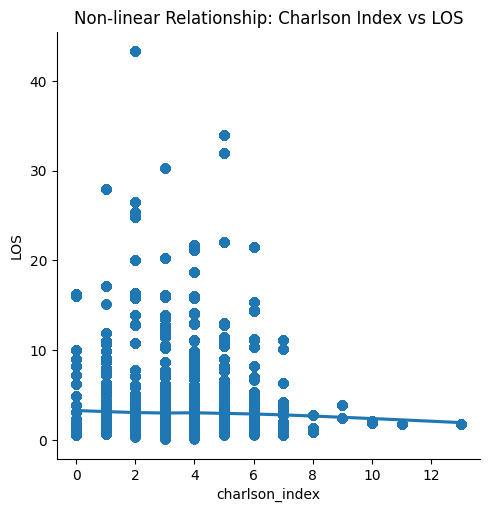

In [769]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lmplot(x='charlson_index', y='LOS', data=dataset, lowess=True)
plt.title('Non-linear Relationship: Charlson Index vs LOS')
plt.show()


In [770]:
corr[abs(corr.iloc[0]) > 0.08].iloc[:,0]

ICUSTAY_ID                                      1.000000
RELIGION_BAPTIST                               -0.089215
ETHNICITY_GROUPED_Other                        -0.109759
ADMISSION_TYPE_ELECTIVE                         0.149270
ADMISSION_TYPE_EMERGENCY                       -0.164796
ADMISSION_LOCATION_PHYS REFERRAL/NORMAL DELI    0.143326
INSURANCE_Government                            0.086628
Name: ICUSTAY_ID, dtype: float64

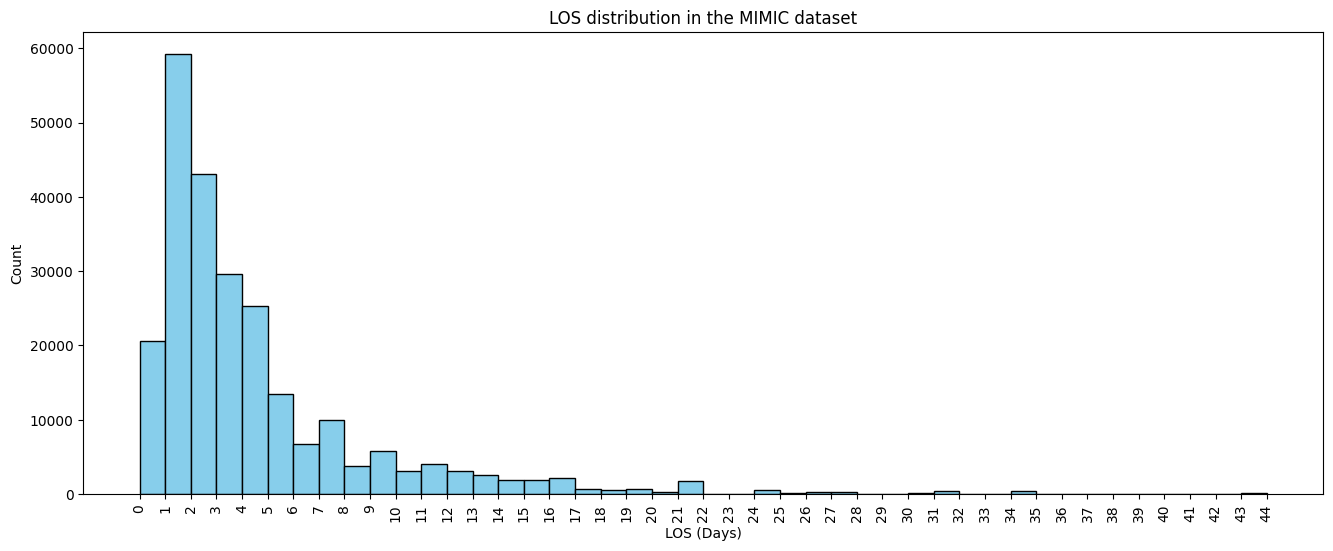

In [771]:
import numpy as np

max_los = int(np.ceil(dataset["LOS"].max()))

plt.figure(figsize=(16, 6))
plt.hist(dataset["LOS"], bins=np.arange(0, max_los + 1, 1), edgecolor='black', color='skyblue')
plt.title("LOS distribution in the MIMIC dataset")
plt.ylabel("Count")
plt.xlabel("LOS (Days)")
plt.xticks(np.arange(0, max_los + 1, step=1), rotation=90)
plt.show()

In [772]:
dataset.ITEMID.nunique()

637

Preprocessing Items table. Needed because a lot of the same items are duplicated with different ITEMIDs. Example: heart rate

In [773]:
print(items[items['ITEMID'] == 211].LABEL)
print(items[items['ITEMID'] == 220045].LABEL)

print("\n")

print(len(items))
items['LABEL'].nunique()

475    Heart Rate
Name: LABEL, dtype: object
11498    Heart Rate
Name: LABEL, dtype: object


12487


11846

In [774]:
dataset = dataset.merge(items[["LABEL", "ITEMID"]], on="ITEMID", how="left")

In [775]:
dataset['LABEL'] = dataset['LABEL'].str.lower()
print(len(dataset[dataset['LABEL'] == "heart rate"]))
print(dataset[dataset['LABEL'] == "heart rate"]["ICUSTAY_ID"].nunique())
result = dataset[dataset['LABEL'] == "heart rate"].groupby('SUBJECT_ID')['ITEMID'].unique()
result

19434
671


SUBJECT_ID
165      [220045.0]
176         [211.0]
177         [211.0]
199         [211.0]
205         [211.0]
            ...    
99893    [220045.0]
99901    [220045.0]
99938    [220045.0]
99944    [220045.0]
99982    [220045.0]
Name: ITEMID, Length: 524, dtype: object

In [776]:
label_counts = dataset.groupby(['LABEL', 'ITEMID'])['ICUSTAY_ID'].nunique().reset_index(name='count')
label_counts = label_counts.sort_values(by='count', ascending=False)
print(label_counts.head(20))

                                       LABEL    ITEMID  count
150                               creatinine  220615.0    717
438                        potassium (serum)  227442.0    717
104                                      bun  225624.0    716
127                         chloride (serum)  220602.0    716
534                           sodium (serum)  220645.0    716
227                             hco3 (serum)  227443.0    716
223                          glucose (serum)  220621.0    711
238                       hematocrit (serum)  220545.0    710
34                                 anion gap  227073.0    710
633                                      wbc  220546.0    708
430                           platelet count  227457.0    708
242                               hemoglobin  220228.0    708
338                                magnesium  220635.0    695
424                              phosphorous  225677.0    654
111                      calcium non-ionized  225625.0    653
496     

In [777]:
dataset = dataset[dataset["ITEMID"].isin([
    211, 220045, 51, 455, 6701, 6, 443, 220179, 618, 220210,
    223900, 226512, 227489, 646, 220277, 220739, 7294, 227446, 225622,
    1525, 220615, 227442, 225624, 220621
])]

label_counts = dataset.groupby('LABEL')['ICUSTAY_ID'].nunique().reset_index(name='count')
label_counts = label_counts.sort_values(by='count', ascending=False)
print(label_counts)

                                   LABEL  count
3                             creatinine    732
8                      potassium (serum)    717
2                                    bun    716
4                        glucose (serum)    711
5                             heart rate    671
9                       respiratory rate    671
7            o2 saturation pulseoxymetry    648
6   non invasive blood pressure systolic    602
0                  admission weight (kg)    554
1         brain natiuretic peptide (bnp)     68
10                                  spo2     22


In [778]:
dataset = dataset[dataset["LABEL"] != "spo2"]
label_counts = dataset.groupby('LABEL')['ICUSTAY_ID'].nunique().reset_index(name='count')
label_counts = label_counts.sort_values(by='count', ascending=False)
print(label_counts)

                                  LABEL  count
3                            creatinine    732
8                     potassium (serum)    717
2                                   bun    716
4                       glucose (serum)    711
5                            heart rate    671
9                      respiratory rate    671
7           o2 saturation pulseoxymetry    648
6  non invasive blood pressure systolic    602
0                 admission weight (kg)    554
1        brain natiuretic peptide (bnp)     68


In [779]:
dataset["VALUE"] = pd.to_numeric(dataset["VALUE"])

In [780]:
print(dataset[dataset["LABEL"] == "admission weight (kg)"]["VALUE"].max())
print(dataset["VALUE"].isna().sum())
dataset["VALUE"].describe()

272.0
0


count    76476.000000
mean        87.813845
std        722.271124
min          0.000000
25%         24.000000
50%         86.150000
75%         99.000000
max      70000.000000
Name: VALUE, dtype: float64

In [781]:
dataset = dataset.dropna(axis=0)

In [782]:
dataset_agg = dataset.groupby(['ICUSTAY_ID', 'LABEL'], as_index=False)['VALUE'].mean()

# Pivot the dataset to transform 'LABEL' into columns
pivoted = dataset_agg.pivot_table(index='ICUSTAY_ID', columns='LABEL', values='VALUE', aggfunc='mean').reset_index()

# Merge the pivoted dataset back with the original dataset, ensuring 'ICUSTAY_ID' stays unique
merged_dataset = dataset.drop(columns=['VALUE', 'LABEL'])  # Drop the 'VALUE' and 'LABEL' columns for the merge
pivoted_dataset = pd.merge(merged_dataset.drop_duplicates(subset=['ICUSTAY_ID']), pivoted, on='ICUSTAY_ID', how='left')

# Show the first 10 rows of the final dataset
pivoted_dataset.head(10)

,ICUSTAY_ID,SUBJECT_ID,HADM_ID,LOS,ADMISSION_TYPE,ADMISSION_LOCATION,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,...,admission weight (kg),brain natiuretic peptide (bnp),bun,creatinine,glucose (serum),heart rate,non invasive blood pressure systolic,o2 saturation pulseoxymetry,potassium (serum),respiratory rate
0,224571,305,122211,0.7925,EMERGENCY,EMERGENCY ROOM ADMIT,Medicare,CATHOLIC,MARRIED,WHITE,...,NaN,NaN,NaN,NaN,NaN,76.681818,NaN,NaN,NaN,13.863636
1,232248,305,122211,5.8118,EMERGENCY,EMERGENCY ROOM ADMIT,Medicare,CATHOLIC,MARRIED,WHITE,...,NaN,NaN,NaN,NaN,NaN,75.228571,NaN,NaN,NaN,15.171429
2,249949,323,106158,4.4319,EMERGENCY,EMERGENCY ROOM ADMIT,Medicare,CATHOLIC,WIDOWED,WHITE,...,NaN,NaN,NaN,NaN,NaN,91.000000,NaN,NaN,NaN,22.444444
3,206073,323,128132,11.9999,EMERGENCY,EMERGENCY ROOM ADMIT,Medicare,CATHOLIC,WIDOWED,WHITE,...,NaN,NaN,NaN,NaN,NaN,84.382353,NaN,NaN,NaN,20.575758
4,281750,351,174800,3.8597,EMERGENCY,EMERGENCY ROOM ADMIT,Government,OTHER,UNKNOWN (DEFAULT),BLACK/AFRICAN AMERICAN,...,NaN,NaN,NaN,NaN,NaN,95.800000,NaN,NaN,NaN,19.333333
5,247247,165,170252,0.9628,EMERGENCY,CLINIC REFERRAL/PREMATURE,Medicare,OTHER,SINGLE,BLACK/AFRICAN AMERICAN,...,70.0,NaN,39.0,2.0,163.0,66.478261,131.217391,98.434783,4.4,17.478261
6,273927,176,135828,0.5142,EMERGENCY,CLINIC REFERRAL/PREMATURE,Medicare,JEWISH,MARRIED,WHITE,...,NaN,NaN,NaN,NaN,NaN,70.250000,NaN,NaN,NaN,16.062500
7,231756,177,143120,9.0276,EMERGENCY,EMERGENCY ROOM ADMIT,Medicare,JEWISH,MARRIED,WHITE,...,NaN,NaN,NaN,NaN,NaN,78.600000,NaN,NaN,NaN,20.400000
8,288571,177,143120,8.2186,EMERGENCY,EMERGENCY ROOM ADMIT,Medicare,JEWISH,MARRIED,WHITE,...,NaN,NaN,NaN,NaN,NaN,85.857143,NaN,NaN,NaN,19.904762
9,255303,177,143120,9.9668,EMERGENCY,EMERGENCY ROOM ADMIT,Medicare,JEWISH,MARRIED,WHITE,...,NaN,NaN,NaN,NaN,NaN,61.647059,NaN,NaN,NaN,18.333333


In [783]:
pivoted_dataset.head()

,ICUSTAY_ID,SUBJECT_ID,HADM_ID,LOS,ADMISSION_TYPE,ADMISSION_LOCATION,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,...,admission weight (kg),brain natiuretic peptide (bnp),bun,creatinine,glucose (serum),heart rate,non invasive blood pressure systolic,o2 saturation pulseoxymetry,potassium (serum),respiratory rate
0,224571,305,122211,0.7925,EMERGENCY,EMERGENCY ROOM ADMIT,Medicare,CATHOLIC,MARRIED,WHITE,...,NaN,NaN,NaN,NaN,NaN,76.681818,NaN,NaN,NaN,13.863636
1,232248,305,122211,5.8118,EMERGENCY,EMERGENCY ROOM ADMIT,Medicare,CATHOLIC,MARRIED,WHITE,...,NaN,NaN,NaN,NaN,NaN,75.228571,NaN,NaN,NaN,15.171429
2,249949,323,106158,4.4319,EMERGENCY,EMERGENCY ROOM ADMIT,Medicare,CATHOLIC,WIDOWED,WHITE,...,NaN,NaN,NaN,NaN,NaN,91.000000,NaN,NaN,NaN,22.444444
3,206073,323,128132,11.9999,EMERGENCY,EMERGENCY ROOM ADMIT,Medicare,CATHOLIC,WIDOWED,WHITE,...,NaN,NaN,NaN,NaN,NaN,84.382353,NaN,NaN,NaN,20.575758
4,281750,351,174800,3.8597,EMERGENCY,EMERGENCY ROOM ADMIT,Government,OTHER,UNKNOWN (DEFAULT),BLACK/AFRICAN AMERICAN,...,NaN,NaN,NaN,NaN,NaN,95.800000,NaN,NaN,NaN,19.333333


In [784]:
pivoted_dataset["brain natiuretic peptide (bnp)"] = pivoted_dataset["brain natiuretic peptide (bnp)"].notna()

After computing correlations we saw weight has almost 0 correlation to LOS, so we drop it since it would make us drop useful rows in the dropna().

In [785]:
pivoted_dataset = pivoted_dataset.drop(columns="admission weight (kg)")

In [786]:
pivoted_dataset = pivoted_dataset.dropna(axis=0)

In [787]:
print(len(pivoted_dataset))
pivoted_dataset.head()

587


,ICUSTAY_ID,SUBJECT_ID,HADM_ID,LOS,ADMISSION_TYPE,ADMISSION_LOCATION,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,...,CHARLSON_IND_FINAL,brain natiuretic peptide (bnp),bun,creatinine,glucose (serum),heart rate,non invasive blood pressure systolic,o2 saturation pulseoxymetry,potassium (serum),respiratory rate
5,247247,165,170252,0.9628,EMERGENCY,CLINIC REFERRAL/PREMATURE,Medicare,OTHER,SINGLE,BLACK/AFRICAN AMERICAN,...,8,False,39.0,2.00,163.0,66.478261,131.217391,98.434783,4.400000,17.478261
16,241803,1354,144830,0.8186,EMERGENCY,PHYS REFERRAL/NORMAL DELI,Medicare,CATHOLIC,MARRIED,WHITE,...,4,False,72.5,1.85,108.5,80.100000,99.714286,96.105263,3.350000,19.800000
18,299666,422,117029,5.1139,EMERGENCY,EMERGENCY ROOM ADMIT,Private,CATHOLIC,MARRIED,WHITE,...,3,False,24.0,1.05,117.5,62.769231,103.916667,93.629630,4.066667,21.115385
25,244320,1578,168848,1.4416,EMERGENCY,EMERGENCY ROOM ADMIT,Medicare,JEWISH,SINGLE,WHITE,...,6,True,51.5,2.05,110.5,62.227273,118.181818,91.260870,4.833333,20.608696
26,239587,1578,144429,1.5444,EMERGENCY,EMERGENCY ROOM ADMIT,Medicare,JEWISH,SINGLE,WHITE,...,7,False,64.5,1.90,142.5,62.043478,112.750000,90.444444,4.250000,21.782609


In [788]:
pivoted_dataset.columns

Index(['ICUSTAY_ID', 'SUBJECT_ID', 'HADM_ID', 'LOS', 'ADMISSION_TYPE',
       'ADMISSION_LOCATION', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS',
       'ETHNICITY', 'charlson_index', 'GENDER', 'comorbidity1_4254',
       'comorbidity1_42731', 'comorbidity1_486', 'comorbidity1_51881',
       'comorbidity1_5849', 'comorbidity2_4254', 'comorbidity2_4280',
       'comorbidity2_42731', 'comorbidity2_5849', 'comorbidity2_5990',
       'ITEMID', 'VALUENUM', 'VALUEUOM', 'DAYS_FROM_INTIME',
       'ETHNICITY_GROUPED', 'AGE', 'age_cat', 'CHARLSON_IND_FINAL',
       'brain natiuretic peptide (bnp)', 'bun', 'creatinine',
       'glucose (serum)', 'heart rate', 'non invasive blood pressure systolic',
       'o2 saturation pulseoxymetry', 'potassium (serum)', 'respiratory rate'],
      dtype='object')

In [790]:
dtemp2 = pivoted_dataset.copy()

dtemp2 = dtemp2[['brain natiuretic peptide (bnp)', 'bun',
       'creatinine', 'glucose (serum)', 'heart rate',
       'non invasive blood pressure systolic', 'o2 saturation pulseoxymetry',
       'potassium (serum)', 'respiratory rate', 'LOS']]

corr = dtemp2.corr(method="spearman")
corr.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1)

,brain natiuretic peptide (bnp),bun,creatinine,glucose (serum),heart rate,non invasive blood pressure systolic,o2 saturation pulseoxymetry,potassium (serum),respiratory rate,LOS
brain natiuretic peptide (bnp),1.000000,0.013756,-0.022041,0.004531,0.102215,0.012440,0.021453,0.044915,0.071440,0.066812
bun,0.013756,1.000000,0.724180,0.045507,-0.140663,-0.085165,0.008744,0.146503,-0.162687,0.253189
creatinine,-0.022041,0.724180,1.000000,-0.024865,-0.165740,0.035381,0.008033,0.190438,-0.176387,0.135600
glucose (serum),0.004531,0.045507,-0.024865,1.000000,0.089300,0.088321,0.026476,0.080593,0.138715,0.039201
heart rate,0.102215,-0.140663,-0.165740,0.089300,1.000000,-0.159126,-0.024495,0.148084,0.325138,0.126385
non invasive blood pressure systolic,0.012440,-0.085165,0.035381,0.088321,-0.159126,1.000000,-0.049071,-0.046406,0.128485,-0.263848
o2 saturation pulseoxymetry,0.021453,0.008744,0.008033,0.026476,-0.024495,-0.049071,1.000000,0.003299,-0.182741,-0.047587
potassium (serum),0.044915,0.146503,0.190438,0.080593,0.148084,-0.046406,0.003299,1.000000,0.030599,0.070375
respiratory rate,0.071440,-0.162687,-0.176387,0.138715,0.325138,0.128485,-0.182741,0.030599,1.000000,-0.007985
LOS,0.066812,0.253189,0.135600,0.039201,0.126385,-0.263848,-0.047587,0.070375,-0.007985,1.000000


In [792]:
len(pivoted_dataset)

587

In [811]:
pivoted_dataset = pivoted_dataset[["bun", "creatinine", "heart rate",
                  "non invasive blood pressure systolic", "ICUSTAY_ID"]]

In [821]:
dtemp_unique = dtemp.drop_duplicates(subset=['ICUSTAY_ID'])
final_dataset = pivoted_dataset.merge(dtemp_unique, on=['ICUSTAY_ID'], how='left')

In [822]:
final_dataset = final_dataset[["comorbidity1_4254", "comorbidity1_51881", "comorbidity1_5849", "comorbidity2_4280", "RELIGION_BUDDHIST", "RELIGION_PROTESTANT QUAKER", 
                  "ETHNICITY_GROUPED_Black", "ETHNICITY_GROUPED_White", "ADMISSION_LOCATION_TRANSFER FROM HOSP/EXTRAM", "GENDER_M", "bun", "creatinine", "heart rate",
                  "non invasive blood pressure systolic", "LOS", "ICUSTAY_ID"]]

In [824]:
print(final_dataset.columns)
print(len(final_dataset))
final_dataset.head()

Index(['comorbidity1_4254', 'comorbidity1_51881', 'comorbidity1_5849',
       'comorbidity2_4280', 'RELIGION_BUDDHIST', 'RELIGION_PROTESTANT QUAKER',
       'ETHNICITY_GROUPED_Black', 'ETHNICITY_GROUPED_White',
       'ADMISSION_LOCATION_TRANSFER FROM HOSP/EXTRAM', 'GENDER_M', 'bun',
       'creatinine', 'heart rate', 'non invasive blood pressure systolic',
       'LOS', 'ICUSTAY_ID'],
      dtype='object')
587


,comorbidity1_4254,comorbidity1_51881,comorbidity1_5849,comorbidity2_4280,RELIGION_BUDDHIST,RELIGION_PROTESTANT QUAKER,ETHNICITY_GROUPED_Black,ETHNICITY_GROUPED_White,ADMISSION_LOCATION_TRANSFER FROM HOSP/EXTRAM,GENDER_M,bun,creatinine,heart rate,non invasive blood pressure systolic,LOS,ICUSTAY_ID
0,False,True,False,False,False,False,True,False,False,True,39.0,2.00,66.478261,131.217391,0.9628,247247
1,False,False,True,False,False,False,False,True,False,True,72.5,1.85,80.100000,99.714286,0.8186,241803
2,False,True,False,False,False,False,False,True,False,True,24.0,1.05,62.769231,103.916667,5.1139,299666
3,False,False,False,False,False,False,False,True,False,False,51.5,2.05,62.227273,118.181818,1.4416,244320
4,False,True,False,False,False,False,False,True,False,False,64.5,1.90,62.043478,112.750000,1.5444,239587


### Training and Validation

### Analysis of Results and Interpretation